# Predicting Chemical Odorant Toxicity from Olfactory Bulb Scans in Mice


# 0. Imports and initializations

This section of the code imports pyrfume a python library which contains toxicity levels of the chemicals. The pytorch, matplotlib and numpy libraries were also imported to be used later in the code.

In [ ]:
!pip install pyrfume

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

import pyrfume
import random


cuda:0


# 1. Data Processing

We have already exported the data (originally stored in MATLAB structures) into single channel 256x256 pngs of the scans. They are stored in the folder `OlfactoryScans`. First clone the repository to access the folder. These scans were provided by the authors of *Mapping odorant sensitivities reveals a sparse but structured representation of olfactory chemical space by sensory input to the mouse olfactory bulb* [(Burton, 2022)](https://elifesciences.org/articles/80470#abstract).

There are 187 odorants tested across 4 mice (total of 4*187 = 748) in the dataset.

Install `pyrfume`, which is a python library containing data on various chemical scents. We will use this to access the [FDA Generally Recognized as Safe dataset](https://www.fda.gov/food/food-ingredients-packaging/generally-recognized-safe-gras).

In [ ]:
!git clone https://github.com/bunnyian/mouse-olfactory-scans

Cloning into 'mouse-olfactory-scans'...
remote: Enumerating objects: 1896, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1896 (delta 1), reused 10 (delta 1), pack-reused 1886
Receiving objects: 100% (1896/1896), 23.71 MiB | 13.57 MiB/s, done.
Resolving deltas: 100% (752/752), done.


In [ ]:
data_transformation = transforms.Compose([transforms.Resize((256,256)), transforms.ToTensor()])


root = '/content/mouse-olfactory-scans/OlfactoryScans'
dataset = datasets.ImageFolder(root=root, transform=data_transformation) # each folder is named as the IUPAC name

In [ ]:
#data_transform = transforms.Compose([
   # transforms.Grayscale(num_output_channels=1),
   # transforms.Resize((256, 256)),
    #transforms.ToTensor()
#])

In [ ]:
# Retrieve folder names from dataset.classes
folder_names = [folder_name.split('/')[-1] for folder_name in dataset.classes] # use folder names as labels rather than ordered numbers

# remove unecessary channels (as it is grayscale, but currenty has 3 channels)
# remove unecessary prelabelling (current label is eg. C1 heptane, instead of just heptane)
# Create a new list to store the modified image and label pairs
modified_dataset = []

# Modify the image and label pairs and store them in the new list
for image, label in dataset:
    image = image[0, :, :]
    label = ' '.join(folder_names[label].split()[1:]) # !!!! ISSUE only has first word
    modified_dataset.append((image, label))

In [ ]:
# replace all labels with 0 or 1, depending on if it is toxic or not
# 0 = non-toxic, 1 = toxic
# match names with the Pyrfume GRAS dataset to get toxicity
manifest = pyrfume.load_manifest("gras") # load the manifest of the GRAS dataset
safe_molecules = pyrfume.load_data("gras/molecules.csv") # molecules that are safe

# make a list of all the names of the safe molecules
safe = []
for i in range(len(safe_molecules)):
    safe.append(safe_molecules.iloc[i]["name"])

toxic = 0
i = 0
labelled_data = []
for image, label in modified_dataset:
    if label in safe:
        labelled_data.append((image, 0))
    elif label == "empty": # the control
        labelled_data.append((image, 0))
    else:
        labelled_data.append((image, 1))
        toxic += 1

print(toxic, "out of", len(dataset), "molecules are toxic, note 187 molecules are repeated 4x")

340 out of 748 molecules are toxic, note 187 molecules are repeated 4x


## Visualize the dataset
An example entry in `modified_dataset` with toxicity labelling applied.

Toxicity label (1 if toxic, 0 if not): 0


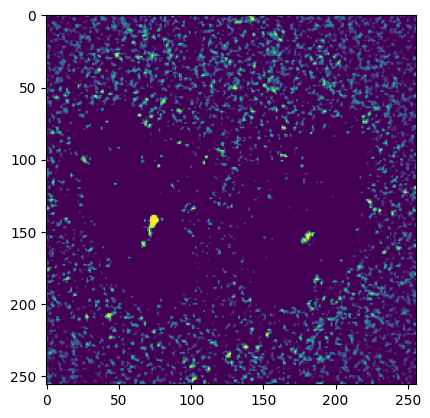

In [ ]:
print("Toxicity label (1 if toxic, 0 if not):", labelled_data[0][1])
plt.imshow(labelled_data[0][0])

In [ ]:
# verify that the data is ready to be used
for image, label in labelled_data:
  if torch.min(image) != 0 or torch.max(image) != 1: #note: technically this data *could* have only values between 0 and 1, but this is just a rough check
                                                     #note: the values were already normalized to [0, 1] from the source, this is just a check
    print("Image not normalized")
  if label not in [0, 1]:
    print("Label not assigned")

## Data split and data loader
Now that `modified_dataset` contains the image tensors and labels as a tuple pair, create an example dataloader to be passed into training.

In [ ]:
train_data, train_label = [], []
val_data, val_label = [], []
test_data, test_label = [], []

total_data = []
total_label = []

# IMPORTANT: shuffle before split
random.seed(0)
random.shuffle(labelled_data)

for image, label in labelled_data:
  total_data.append(image)
  total_label.append(label)

length = len(labelled_data)
train_data, val_data, test_data = total_data[:int(length*.7)], total_data[int(length*.7)+1:int(length*.85)], total_data[int(length*.85)+1:]
train_label, val_label, test_label = total_label[:int(length*.7)], total_label[int(length*.7)+1:int(length*.85)], total_label[int(length*.85)+1:]

# check train/val/test split
print(len(train_data), len(train_label))
print(len(val_data), len(val_label))
print(len(test_data), len(test_label))
print(len(train_data)+len(val_data)+len(test_data)) # split contains total 746/748

523 523
111 111
112 112
746


In [ ]:
# Convert lists to tensors to be used in DataLoaders
train_data = torch.stack(train_data) # originally a list of tensors
train_label = torch.tensor(train_label) # originally a list of integer labels
val_data = torch.stack(val_data)
val_label = torch.tensor(val_label)
test_data = torch.stack(test_data)
test_label = torch.tensor(test_label)

# Create TensorDataset
train_dataset = TensorDataset(train_data, train_label)
val_dataset = TensorDataset(val_data, val_label)
test_dataset = TensorDataset(test_data, test_label)

# Example usage of the datasets in a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size= 32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size= 32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size= 32, shuffle=False)

# 2. Baseline Model


We compare various baseline models using the sklearn package to help us assess whether our data is useful enough to make predictions. The following models were also selected to see if we could learn from their functionality and results to guide our Primary Model

### State Vector Machine Classifier
The State Vector Machine (SVM) Classifier is used here as it is good at classification and feature recognition which is what we want to achieve. We want to asses features within our images to help label them as toxic and non-toxic

In [ ]:
#State Vector Machine Classifier
from sklearn import svm
svm_model = svm.SVC(gamma=2, C=0.5)

# Flatten the image tensors for State Vector Machiene
train_data_flat = train_data.view(train_data.size(0), -1).numpy()
val_data_flat = val_data.view(val_data.size(0), -1).numpy()
test_data_flat = test_data.view(test_data.size(0), -1).numpy()

# Train Model
svm_model.fit(train_data_flat, train_label)

# Evaluate the model on the validation set
val_predictions = svm_model.predict(val_data_flat)
val_accuracy = (val_predictions == val_label.numpy()).mean()
print("Validation Accuracy:", 100*(val_accuracy))

# Evaluate the model on the test set
test_predictions = svm_model.predict(test_data_flat)
test_accuracy = (test_predictions == test_label.numpy()).mean()
print("Test Accuracy:", 100*(test_accuracy))

Validation Accuracy: 59.45945945945946
Test Accuracy: 61.60714285714286


### Random Forest Classifier
The Random Forest (RF) Classifier is useful for classification and less susceptible to noise which is ideal in the evaluation of our data.

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Flatten the image tensors for Random Forest
train_data_flat = train_data.view(train_data.size(0), -1).numpy()
val_data_flat = val_data.view(val_data.size(0), -1).numpy()
test_data_flat = test_data.view(test_data.size(0), -1).numpy()

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, random_state=0)
rf_model.fit(train_data_flat, train_label)

# Evaluate the model on the validation set
val_predictions = rf_model.predict(val_data_flat)
val_accuracy = (val_predictions == val_label.numpy()).mean()
print("Validation Accuracy:", 100*(val_accuracy))

# Evaluate the model on the test set
test_predictions = rf_model.predict(test_data_flat)
test_accuracy = (test_predictions == test_label.numpy()).mean()
print("Test Accuracy:", 100*(test_accuracy))


Validation Accuracy: 60.36036036036037
Test Accuracy: 62.5


### Naive Bayes Classifier
The Naive Bayes (NB) Classiffier is useful for classification problems which is the core of our project.

In [ ]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()

# Flatten the image tensors for Naive Bayes
train_data_flat = train_data.view(train_data.size(0), -1).numpy()
val_data_flat = val_data.view(val_data.size(0), -1).numpy()
test_data_flat = test_data.view(test_data.size(0), -1).numpy()

# Train Model
nb_model.fit(train_data_flat, train_label)

# Evaluate the model on the validation set
val_predictions = nb_model.predict(val_data_flat)
val_accuracy = (val_predictions == val_label.numpy()).mean()
print("Validation Accuracy:", 100*(val_accuracy))

# Evaluate the model on the test set
test_predictions = nb_model.predict(test_data_flat)
test_accuracy = (test_predictions == test_label.numpy()).mean()
print("Test Accuracy:", 100*(test_accuracy))


Validation Accuracy: 54.054054054054056
Test Accuracy: 51.78571428571429


# 3. Primary Model

This section consists of our Primary Model, Hyperparameter search and Training

## Architecture and Train Functions

This section consists of all the necessary functions for training and architecture

In [ ]:
# Aside: demonstrate output size calculations
def conv_out(input_size, kernel_size, stride, padding):
    # Calculate the output size of a square convolutional layer.

    # Calculate the output size
    output_size = ((input_size + 2 * padding - kernel_size) // stride) + 1
    return output_size

def pool_out(input_size, kernel_size, stride):
    # Calculate the output size of a square max pool layer.

    # Calculate the output size
    output_size = ((input_size - kernel_size) // stride) + 1
    return output_size

In [ ]:
l1 = conv_out(256, 3, 2, 2)
l2 = pool_out(l1, 3, 1)
l3 = conv_out(l2, 3, 2, 0)
l4 = pool_out(l3, 3, 1)
l5 = conv_out(l4, 3, 2, 2)

print(l1,l2,l3,l4,l5)

129 127 63 61 32


In [ ]:
# Model Architecture
# 748 imgs, 1 channel, 256 * 256
class PrimaryModel(nn.Module):
    def __init__(self):
        super(PrimaryModel, self).__init__()
        # Convolutional Neural Network (CNN) for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=2), # 1ch in, 16 out
            nn.ReLU(),
            nn.MaxPool2d(3, 1), # Pool kernel size 3, stride = 1
            nn.Conv2d(16, 8, kernel_size=3, stride=2), # 16ch in, 8ch out
            nn.ReLU(),
            nn.MaxPool2d(3, 1), # Pool kernel size 3, stride = 1
            nn.Conv2d(8, 4, kernel_size=3, stride=2, padding=2), # 8ch in, 4ch out
            # output is 4x32x32
        )

        # Artificial Neural Network (ANN) for classification
        self.ann = nn.Sequential(
            nn.Linear(4 * 32 * 32, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            # Output sigmoid activation for range between 0 and 1 ---- DONE THRU BCEwLogits
        )

    def forward(self, x):
        # Pass the input through the CNN for feature extraction
        features = self.cnn(x.unsqueeze(1))

        # Flatten the features to be compatible with the ANN
        features = features.view(features.size(0), -1)

        # Pass the flattened features through the ANN for classification
        output = self.ann(features)

        return output

In [ ]:
# Model Accuracy Function
# TODO: implement decision matrix (false positive, etc.)
def get_accuracy(model, data):
  total = 0
  correct = 0

  for images, labels in data:
    images = images.to(device)
    labels = labels.to(device)

    out = model(images)
    prediction = torch.sigmoid(out)

    for i in range(len(labels)):
      if (prediction[i] <0.5 and labels[i] == 0) or (prediction[i] >=0.5 and labels[i] == 1):
        correct += 1

      total += 1

  return correct/total

In [ ]:
# Model Train Function
def train(model, batchsz, lr, momentum, num_epochs, plot = False, history = False):
  # prepare dataloaders
  train_dataloader = DataLoader(train_dataset, batch_size= batchsz, shuffle=True)

  # Define the loss function and optimizer
  criterion = nn.BCEWithLogitsLoss() # built in sigmoid
  optimizer = torch.optim.SGD(model.parameters(), lr, momentum)

  loss_history = []
  train_acc_history = []
  val_acc_history = []
  for epoch in range(num_epochs):
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Backward pass and optimization
        loss = criterion(outputs, torch.tensor(labels.float()).unsqueeze(1))
        loss_history.append(loss)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # epoch training accuracy
    accuracy = get_accuracy(model, train_dataloader)
    train_acc_history.append(accuracy)
    #print("Training accuracy for epoch", epoch,"is", accuracy)

    # epoch validation accuracy
    accuracy = get_accuracy(model, DataLoader(val_dataset, batch_size= batchsz, shuffle=True))
    val_acc_history.append(accuracy)


  if plot:
      # Plotting accuracy curve
      plt.title("Accuracy Curve")
      plt.plot(list(range(0, num_epochs)), train_acc_history, label="Train")
      plt.plot(list(range(0, num_epochs)), val_acc_history, label="Validation")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()

  if history:
    return val_acc_history, loss_history

In [ ]:
# Run a training session
model = PrimaryModel()
model.to(device)

train(model, 64, 0.01, 0.9, 50, True)

KeyboardInterrupt: ignored

In [ ]:
#test dataloader
accuracy = get_accuracy(model, DataLoader(test_dataset, batch_size= 64, shuffle=True))
accuracy # test accuracy

In [ ]:
# Run a training session
model = PrimaryModel()
model.to(device)

train(model, 256, 0.005, 0.9, 250, True)

## Hyperparameter Search
Implemented grid search to find the optimal hyperparameters

In [ ]:
# Define hyperparameters for grid search
batch_sizes = [128, 256]
learning_rates = [0.001, 0.005, 0.01]
momentum_values = [0.85, 0.9, 0.95]
num_epochs = -1 # adjust later on depending on batch size
                # early stopping used!

best_val_accuracy = 0.0
best_hyperparameters = {} # dictionary to refer back
best_epoch = 0 # since we are training 50 epochs for each model, but then keeping the val accuracy for each
               # epoch so we know if we should do an early stop (rather than training the same settings at multiple diff
               # epochs)

for batch_size in batch_sizes:
    # num epochs
    # train set is 523 images
    # aim for ~500 iterations per model (arbitrary decided)
    # 500 = (523 * num_epochs)/batch
    num_epochs = int((500*batch_size)/523)

    for learning_rate in learning_rates:
        for momentum in momentum_values:
            model = PrimaryModel()
            model.to(device)

            # Train the model, note that plotting turned OFF, (returning validation) history turned ON
            val_acc_history = train(model, batch_size, learning_rate, momentum, num_epochs, plot = False, history = True)

            max_val_accuracy = max(val_acc_history)
            max_epoch = val_acc_history.index(max_val_accuracy) + 1 # index starts at 0

            # check if this tuning is better than previous
            if max_val_accuracy > best_val_accuracy:
                best_val_accuracy = max_val_accuracy
                best_hyperparameters = {
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'momentum': momentum
                }
                best_epoch = max_epoch


    print("Finished training batch sz", batch_size)

print("Best Hyperparameters:", best_hyperparameters)
print("Maximum Validation Accuracy:", best_val_accuracy)
print("At Epoch:", best_epoch)



Crashed at batch = 512, lr = 0.01, momentum = 0.85

In [ ]:
#best results up to that point were
best_hyperparameters # {'batch_size': 256 b, 'learning_rate': 0.01, 'momentum': 0.95}

In [ ]:
best_epoch #57

In [ ]:
best_val_accuracy # 0.71171

Repeat the last section of grid search before crash

In [ ]:
# Define hyperparameters for grid search
batch_sizes = [512]
learning_rates = [0.01, 0.05, 0.1]
momentum_values = [0.85, 0.9, 0.95, 0.99]
num_epochs = -1 # adjust later on depending on batch size

best_val_accuracy = 0.0
best_hyperparameters = {} # dictionary to refer back
best_epoch = 0 # since we are training 50 epochs for each model, but then keeping the val accuracy for each
               # epoch so we know if we should do an early stop (rather than training the same settings at multiple diff
               # epochs)

for batch_size in batch_sizes:
    # num epochs
    # train set is 523 images
    # aim for ~500 iterations per model (arbitrary decided)
    # 500 = (523 * num_epochs)/batch
    num_epochs = int((500*batch_size)/523)

    for learning_rate in learning_rates:
        for momentum in momentum_values:
            model = PrimaryModel()
            model.to(device)

            # Train the model, note that plotting turned OFF, (returning validation) history turned ON
            val_acc_history = train(model, batch_size, learning_rate, momentum, num_epochs, plot = False, history = True)

            max_val_accuracy = max(val_acc_history)
            max_epoch = val_acc_history.index(max_val_accuracy) + 1 # index starts at 0

            # check if this tuning is better than previous
            if max_val_accuracy > best_val_accuracy:
                best_val_accuracy = max_val_accuracy
                best_hyperparameters = {
                    'batch_size': batch_size,
                    'learning_rate': learning_rate,
                    'momentum': momentum
                }
                best_epoch = max_epoch


    print("Finished training batch sz", batch_size)

print("Best Hyperparameters:", best_hyperparameters)
print("Maximum Validation Accuracy:", best_val_accuracy)
print("At Epoch:", best_epoch)

## Best Model

Training with the best hyperparameters found through grid search

In [ ]:
model = PrimaryModel()
model.to(device)


#best_hyperparameters
# {'batch_size': 256, 'learning_rate': 0.01, 'momentum': 0.95}
# epoch 57

# after new search
# Best Hyperparameters:
{'batch_size': 256, 'learning_rate': 0.005, 'momentum': 0.9}
# Maximum Validation Accuracy: 0.7027027027027027
# At Epoch: 142

val_his, loss_history = train(model, 256, 0.005, 0.9, 175, plot=True, history = True)

KeyboardInterrupt: ignored

NameError: ignored

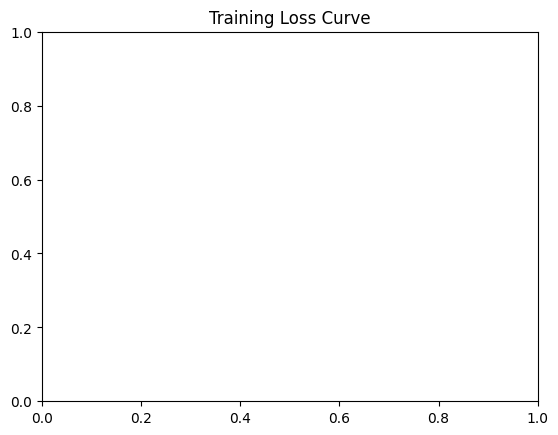

In [ ]:
# Plotting loss curve
plt.title("Training Loss Curve")
loss_hist = torch.stack(loss_history).cpu().detach()
plt.plot(list(range(0, len(loss_hist))), loss_hist, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

<ipython-input-15-c0895cf2adb0>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels.float()).unsqueeze(1))


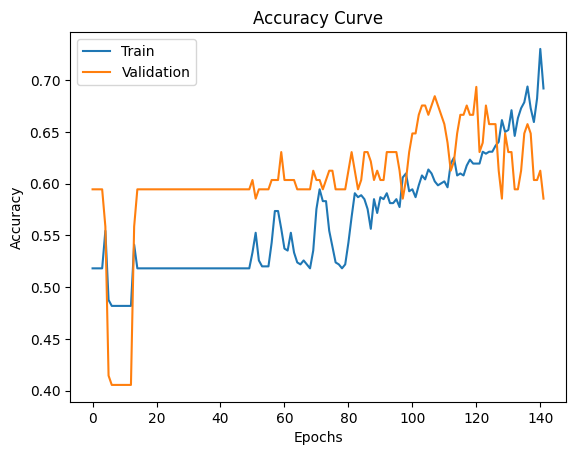

In [ ]:
model = PrimaryModel()
model.to(device)


#best_hyperparameters # {'batch_size': 256, 'learning_rate': 0.01, 'momentum': 0.95}
# epoch 57

# after new search
# Best Hyperparameters: {'batch_size': 256, 'learning_rate': 0.005, 'momentum': 0.9}
# Maximum Validation Accuracy: 0.7027027027027027
# At Epoch: 142

val_his, loss_history = train(model, 256, 0.005, 0.9, 142, plot=True, history = True)

# Test final model on test dataset


In [ ]:
#test dataloader
accuracy = get_accuracy(model, DataLoader(test_dataset, batch_size= 256, shuffle=True))

In [ ]:
accuracy #final test accuracy

0.5714285714285714

1. Show Convolutional Kernels for qualitative result
2. testing sample

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Project/Final Model Torch/model.pth") # best model already saved at 0.64 accuracy

In [ ]:
test_save = PrimaryModel()
test_save.to(device)
test_save.load_state_dict(torch.load("/content/drive/MyDrive/Project/Final Model Torch/model.pth"))
test_save.eval()

PrimaryModel(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  )
  (ann): Sequential(
    (0): Linear(in_features=4096, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [ ]:
get_accuracy(test_save, DataLoader(test_dataset, batch_size= 256, shuffle=True))

0.6428571428571429

In [ ]:
def confusion_acc(model, data, device):
    total = 0
    correct = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0

    for images, labels in data:
        images = images.to(device)
        labels = labels.to(device)

        out = model(images)
        prediction = torch.sigmoid(out)

        for i in range(len(labels)):

            if (prediction[i] < 0.5 and labels[i] == 0):
                true_negative += 1
            elif (prediction[i] >= 0.5 and labels[i] == 1):
                true_positive += 1
            elif (prediction[i] >= 0.5 and labels[i] == 0):
                false_positive += 1
            else:
                false_negative += 1

            total += 1

    accuracy = (true_positive + true_negative) / total
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    false_positive_rate = false_positive / (false_positive + true_negative)
    false_negative_rate = false_negative / (false_negative + true_positive)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate: {true_positive_rate:.4f}")
    print(f"True Negative Rate: {true_negative_rate:.4f}")
    print(f"False Positive Rate: {false_positive_rate:.4f}")
    print(f"False Negative Rate: {false_negative_rate:.4f}")


    return accuracy, true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate


In [ ]:
confusion_acc(model, DataLoader(test_dataset, batch_size= 256, shuffle=True), device)

Number of Positive Samples: 43
Number of Negative Samples: 69
Accuracy: 0.6429
True Positive Rate: 0.3256
True Negative Rate: 0.8406
False Positive Rate: 0.1594
False Negative Rate: 0.6744


(0.6428571428571429,
 0.32558139534883723,
 0.8405797101449275,
 0.15942028985507245,
 0.6744186046511628)

# Demonstration


*   Extract Kernels
*   Make predictions on two test images
*   Show effect of convolutional kernels



# Kernel Extraction

In [ ]:
kernels1 = model.cnn[0].weight.detach().cpu()
kernels2 = model.cnn[3].weight.detach().cpu()
kernels3 = model.cnn[6].weight.detach().cpu()

In [ ]:
import scipy.signal as sg
def apply_conv(kernels, img):
  for i in range(kernels.shape[0]):
    kern = kernels[i][0]
    img_k = sg.convolve(img, kern)

    img_k = (img_k-img_k.min())/(img_k.max()-img_k.min())*255

    img_k = img_k.astype(np.uint8)


  plt.imshow(img_k, "Greys")

  return img_k

# Toxic Example

In [ ]:
example = test_dataset[0] # index 0 is toxic example
print(example[1]) # label 1 = toxic
img = example[0].cpu()

plt.imshow(img, "Greys")

NameError: ignored

In [ ]:
out = model(img.unsqueeze(0).cuda())

In [ ]:
# PREDICTION
torch.sigmoid(out)

tensor([[0.5391]], device='cuda:0', grad_fn=<SigmoidBackward0>)

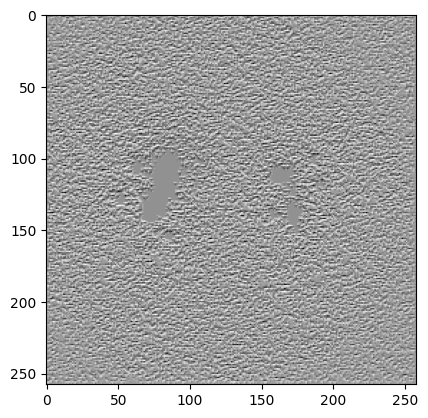

In [ ]:
img_1 = apply_conv(kernels1, img)

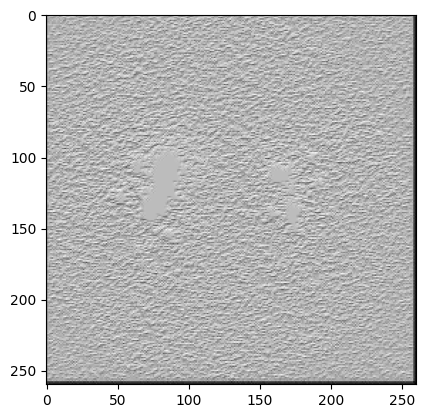

In [ ]:
img_2 = apply_conv(kernels2, img_1)

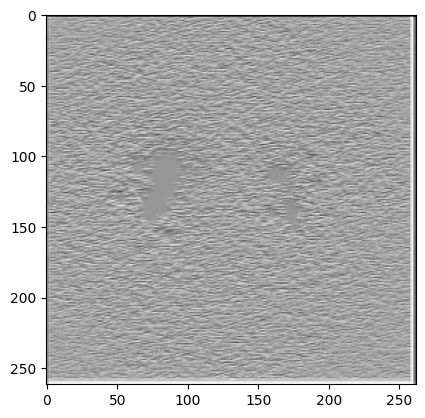

In [ ]:
img_3 = apply_conv(kernels3, img_2)

# Non-toxic Example

tensor(0)


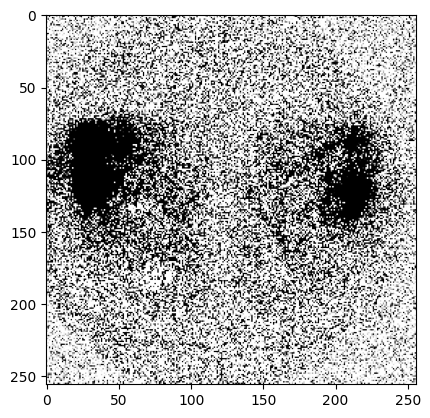

In [ ]:
example = test_dataset[1]
print(example[1]) # label 0 = safe
img = example[0].cpu()

plt.imshow(img, "Greys")

In [ ]:
out = model(img.unsqueeze(0).cuda())

In [ ]:
# PREDICTION
torch.sigmoid(out)

tensor([[0.5415]], device='cuda:0', grad_fn=<SigmoidBackward0>)

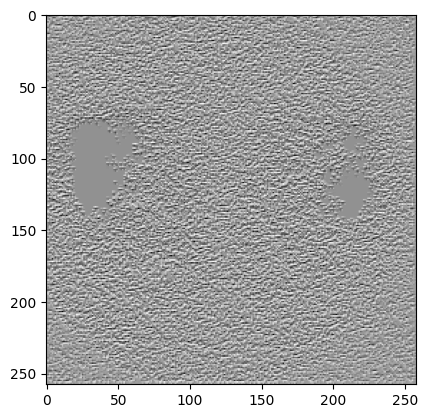

In [ ]:
img_1 = apply_conv(kernels1, img)

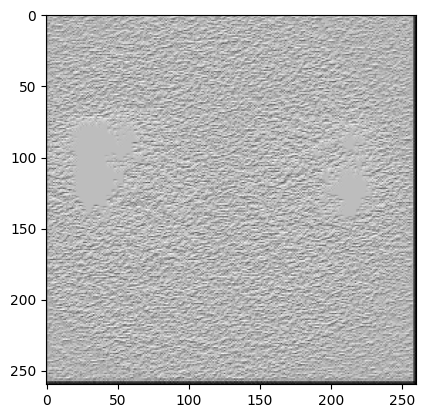

In [ ]:
img_2 = apply_conv(kernels2, img_1)

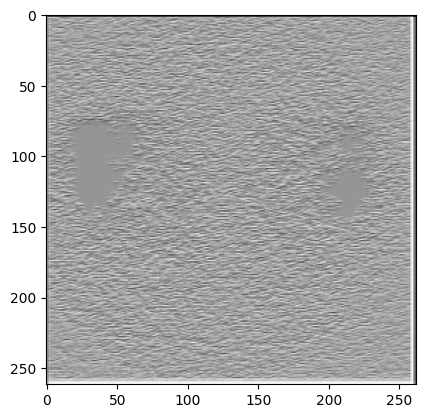

In [ ]:
img_3 = apply_conv(kernels3, img_2)

# Test on Other Study


# incorrect  Toxic Example

tensor(1)


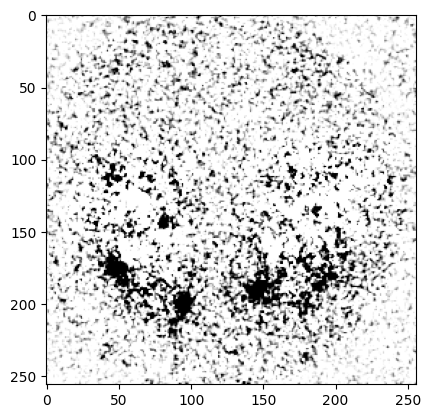

In [ ]:
example = test_dataset[11] # index 0 is toxic example
print(example[1]) # label 1 = toxic
img = example[0].cpu()

plt.imshow(img, "Greys")

In [ ]:
out = model(img.unsqueeze(0).cuda())

In [ ]:
# PREDICTION
torch.sigmoid(out)

tensor([[0.3199]], device='cuda:0', grad_fn=<SigmoidBackward0>)

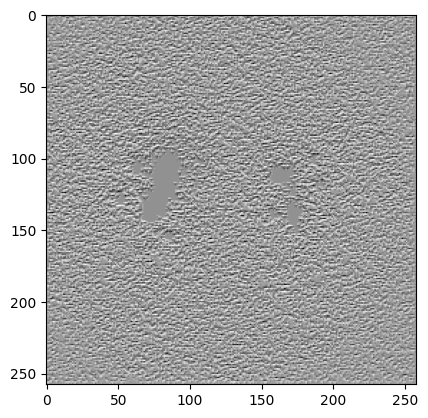

In [ ]:
img_1 = apply_conv(kernels1, img)

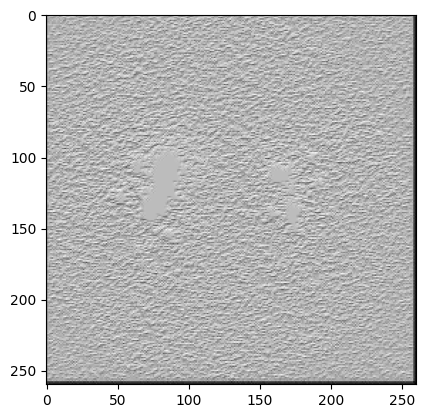

In [ ]:
img_2 = apply_conv(kernels2, img_1)

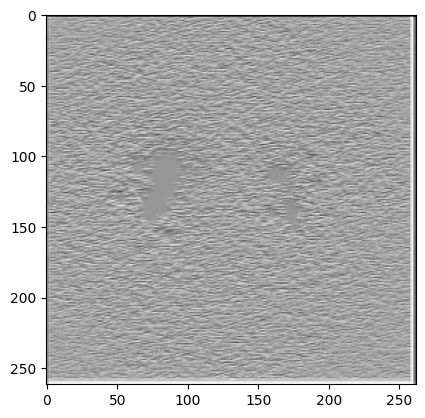

In [ ]:
img_3 = apply_conv(kernels3, img_2)

# incorrect Non-toxic Example

tensor(0)


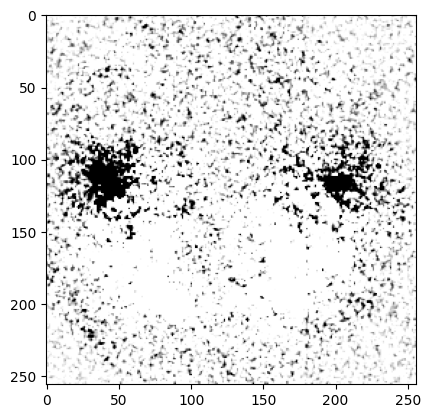

In [ ]:
example = test_dataset[2]
print(example[1]) # label 0 = safe
img = example[0].cpu()

plt.imshow(img, "Greys")

In [ ]:
out = model(img.unsqueeze(0).cuda())

In [ ]:
# PREDICTION
torch.sigmoid(out)

tensor([[0.7953]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
img_1 = apply_conv(kernels1, img)

NameError: ignored

In [ ]:
img_2 = apply_conv(kernels2, img_1)

In [ ]:
img_3 = apply_conv(kernels3, img_2)